In [1]:
library("readxl")

Warning message:
"package 'readxl' was built under R version 3.6.3"

In [2]:
library("lubridate")
library('tidyr')
library('ggplot2')

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union

Warning message:
"package 'tidyr' was built under R version 3.6.3"

In [3]:
search()

[1] ".GlobalEnv"        "package:ggplot2"   "package:tidyr"    
 [4] "package:lubridate" "package:readxl"    "jupyter:irkernel" 
 [7] "jupyter:irkernel"  "package:stats"     "package:graphics" 
[10] "package:grDevices" "package:utils"     "package:datasets" 
[13] "package:methods"   "Autoloads"         "package:base"

In [4]:
source("helpers.R")

In [5]:
path <- "../data/data.xlsx"

In [6]:
df <- Dataframing(path)

In [7]:
df <- df[-c(210),]

In [8]:
df$Date <- as.Date(df$Date)

In [9]:
firstYields <- df[df$Date == "2022-02-11",]

In [10]:
firstYields

,Date,10Y,7Y,5Y,3Y,2Y,1Y,6M,3M
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
209,2022-02-11,1.941,1.94,1.856,1.728,1.505,1.029,0.692,0.359


#### Suponemos que: 
- $\alpha_1$ representa la tasa forward entre 0 y 3 meses, 
- $\alpha_2$ la tasa entre 3 meses y 1 año, 
- $\alpha_3$ la tasa entre 1 y 3 años,
- $\alpha_4$ la tasa entre 3 y 5 años ,
- $\alpha_5$ la tasa entre 5 y 10 años. 

In [11]:
today <- firstYields$Date

#### Además, para traer a valor presente usando una curva forward, se sigue el factor de descuento a un plazo T es: 

### $$ e^{-\int_{0}^{T} f(t) \,dt}$$

#### Definamos algunos objetos de utilidad. Cuántos cupones paga cada bono? Cómo ajustamos la tasa para cada pago?

In [12]:
alpha <- c(0.1,0.11,0.12,0.13,0.14)

[1] 0.10 0.11 0.12 0.13 0.14

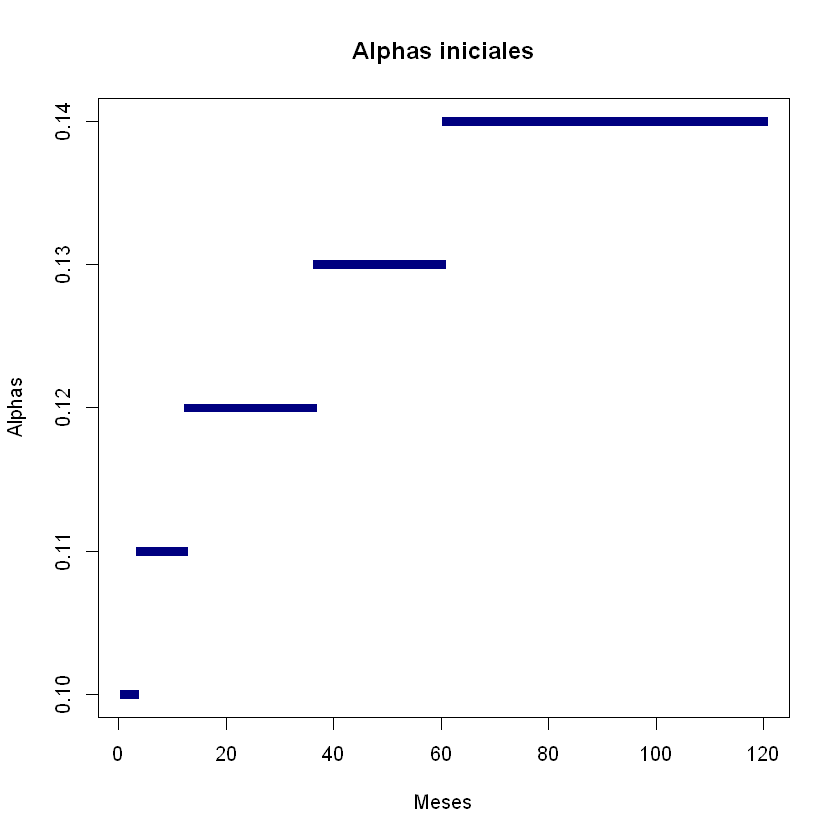

In [13]:
alpha
xx <- c(1:120)
aa <- alphacuts(alpha)
plot(xx,aa, type= "p",
            pch=22, 
            bg = "navy", 
            col = "navy", 
            main= "Alphas iniciales", 
            xlab = "Meses", 
            ylab = "Alphas")

In [14]:
today = firstYields$Date

In [15]:
threeMonthBond <- 100 + RateConverter(firstYields[["3M"]],3,today)*DiscountFactor(alpha, 3)
threeMonthBond
RateConverter(firstYields[["3M"]],3,today)

RateConverter(firstYields[["1Y"]],12,today)


[1] 100.0192

[1] 0.01970469

[1] 0.4303246

In [16]:
sixMonthBond <- 100 + RateConverter(firstYields[["6M"]], 6, today)*DiscountFactor(alpha, 6)

In [17]:
sixMonthBond

[1] 100.1435

In [18]:
oneYearBond <- 100 +  RateConverter(firstYields[["1Y"]], 6, today) *DiscountFactor(alpha, 6) + RateConverter(firstYields[["1Y"]], 12, today)*DiscountFactor(alpha, 12)

In [19]:
oneYearBond

[1] 100.5889

In [20]:
maturity<- 36

In [21]:
periods <- seq(6, maturity, 6)

In [22]:
threeMonthBond

[1] 100.0192

Recordemos que cada pago está dado por :  

$$\$100\times R \times \frac{ACT}{360}$$

In [23]:
singleBondPayment <- function(maturity, yield, alpha, today){
    return (RateConverter(yield, maturity,today)*DiscountFactor(alpha, maturity))
}

In [24]:
singleBondPayment(120,firstYields[["10Y"]], alpha, today)
firstYields[["10Y"]]

[1] 1.961799

[1] 1.941

In [25]:
yieldList <- list(firstYields)

In [26]:
nombres <- colnames(firstYields)

In [27]:
nombres <- nombres[-1]

In [28]:
nombres

[1] "10Y" "7Y"  "5Y"  "3Y"  "2Y"  "1Y"  "6M"  "3M"

In [29]:
nombres <- as.list(nombres)

In [30]:
names(nombres) <- c(120,84,60,36,24,12,6,3) 

In [31]:
BondValue <- function (today, maturity, yieldlist,alpha ){
    if (maturity == 3){
        return (100*DiscountFactor(alpha, maturity) + singleBondPayment(3,yieldlist[["3M"]], alpha, today))
        }
    setter <- as.character(maturity)
    periods <- seq(6, maturity, 6)
    bondSum <- sum(unlist(lapply(periods, function(x) singleBondPayment(x, yield = yieldlist[[nombres[[setter]]]],  alpha = alpha, today = today))))
    return(bondSum +100*DiscountFactor(alpha, maturity))
}



In [32]:
BondValue(today, 120, firstYields, alpha)

[1] 60.82667

In [33]:
maturities <- c(120,84,60,36,24,12,6,3) 

In [34]:
alpha <- c(0.00343, 0.0105, 0.0817, 0.1598, 0.2744)
bondValues <- list()
for (i in maturities){
    bondValues <- append(bondValues, BondValue(today, i, firstYields, alpha))
}

In [35]:
bondValues

[[1]]
[1] 47.00202

[[2]]
[1] 58.45278

[[3]]
[1] 75.90743

[[4]]
[1] 90.43397

[[5]]
[1] 94.15173

[[6]]
[1] 99.76979

[[7]]
[1] 99.80305

[[8]]
[1] 99.93397

In [36]:
error <-function(alpha){
    maturities <- c(3,6,12,24,36,60,84,120) 
    bondValues <- list()
    for (i in maturities){
        bondValues <- append(bondValues, BondValue(today, i, firstYields, alpha))
    }
    error <- sum((unlist(bondValues)-100)**2)
    return (error)
}

error(alpha)

[1] 5241.216

In [37]:
opt <- optim(alpha, error, lower = 0, upper= 1, method = "L-BFGS-B")

[1] 0.0009475823 0.0047407709 0.0310741501 0.0572666472 0.1085754109

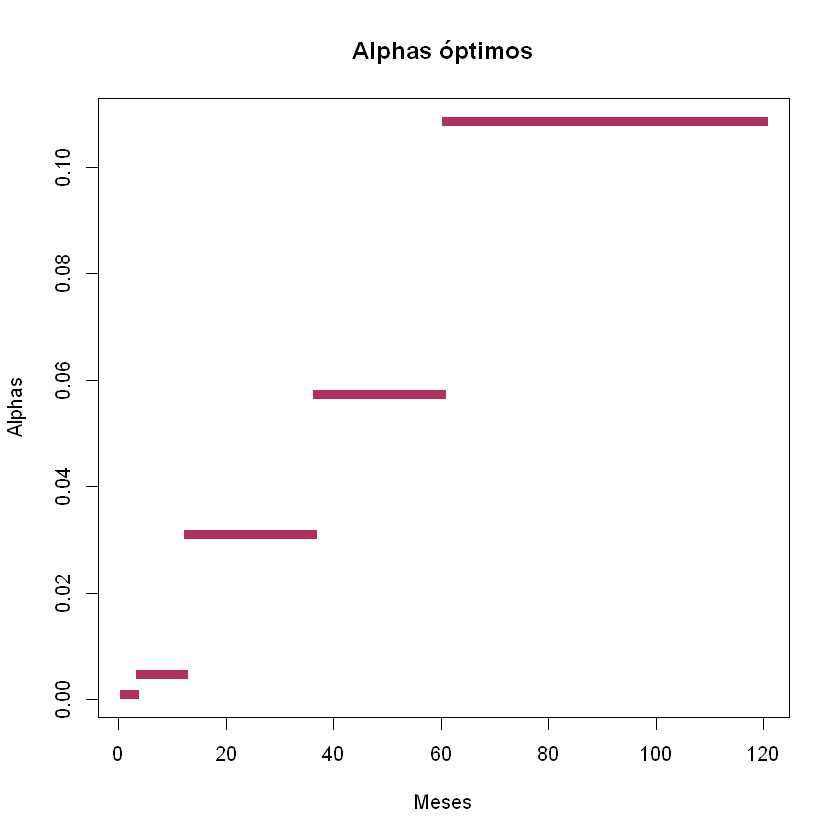

In [38]:
alpha <- opt$par
alpha
xx <- c(1:120)
aa <- alphacuts(alpha)
plot(xx,aa, type= "p",
            pch=22, 
            bg = "maroon", 
            col = "maroon", 
            main= "Alphas óptimos", 
            xlab = "Meses", 
            ylab = "Alphas")

Valoración de bono de 7 años

In [39]:
alpha <- opt$par
pvnotional <- 100 - DiscountFactor(alpha[4], 84)*100
pvnotional
couponsum <- function (c){
    pvcoupon <- DiscountFactor(alpha[2], 12)*RateConverter(c, 12,today) + DiscountFactor(alpha[2], 24)*RateConverter(c,24,today) +
        DiscountFactor(alpha[3], 36)*RateConverter(c, 36,today) +DiscountFactor(alpha[3], 48)*RateConverter(c, 48,today) +
        DiscountFactor(alpha[4], 60)*RateConverter(c, 60,today) + DiscountFactor(alpha[4], 72)*RateConverter(c, 72,today) +  
        DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today) + DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today)
        result <-pvnotional- pvcoupon
    if (result <0){
        return (500)
    }
    else {
        return (pvnotional- pvcoupon)
    }
    
}

opti <- optim(c,couponsum,lower = 0, upper=10,  method = "Brent")
opti


[1] 33.02606

$par
[1] 3.939572

$value
[1] 6.409757e-07

$counts
function gradient 
      NA       NA 

$convergence
[1] 0

$message
NULL

Matriz de curvas 1 año en el pasado

In [40]:

matAlphas <- list()
df <- df[(nrow(df)-52):nrow(df),]
for ( r in 1:nrow(df)){ 
    firstYields <- df[r,]
    today <- firstYields$Date
    alpha <- opt$par
    opt <- optim(alpha, error, lower = 0, upper= 1, method = "L-BFGS-B")
    matAlphas <- append(matAlphas, list(opt$par))
}

In [41]:
MatofAlphas <- matrix(unlist(matAlphas), ncol = 5, byrow = TRUE)
MatofAlphas

0.0000000000,0.000000e+00,0.004479686,0.01840584,0.09237962
0.0000000000,0.000000e+00,0.004706973,0.02325406,0.09939886
0.0000000000,0.000000e+00,0.006106605,0.03171539,0.10005125
0.0000000000,0.000000e+00,0.006740558,0.03408666,0.10965079
0.0000000000,0.000000e+00,0.007353796,0.03552450,0.11252459
0.0000000000,0.000000e+00,0.007191029,0.03778698,0.11806777
0.0000000000,0.000000e+00,0.006776310,0.03766010,0.11542087
0.0000000000,0.000000e+00,0.008363223,0.04205166,0.11554998
0.0000000000,0.000000e+00,0.007303816,0.03692244,0.11421266
0.0000000000,0.000000e+00,0.007467144,0.03518958,0.10970437
0.0000000000,0.000000e+00,0.007301729,0.03480937,0.10857967


In [42]:
write.csv(MatofAlphas,"../data/sim.csv", row.names = FALSE)

In [43]:
MatofAlphas <- read.csv("../data/sim.csv")
i_alpha <- MatofAlphas[-nrow(MatofAlphas),]
f_alpha <- MatofAlphas[-1,]
delta_alpha <- f_alpha - i_alpha
cov_delta_a <- cov(delta_alpha)
MatofAlphas
cov_delta_a

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0000000000,0.000000e+00,0.004479686,0.01840584,0.09237962
0.0000000000,0.000000e+00,0.004706973,0.02325406,0.09939886
0.0000000000,0.000000e+00,0.006106605,0.03171539,0.10005125
0.0000000000,0.000000e+00,0.006740558,0.03408666,0.10965079
0.0000000000,0.000000e+00,0.007353796,0.03552450,0.11252459
0.0000000000,0.000000e+00,0.007191029,0.03778698,0.11806777
0.0000000000,0.000000e+00,0.006776310,0.03766010,0.11542087
0.0000000000,0.000000e+00,0.008363223,0.04205166,0.11554998
0.0000000000,0.000000e+00,0.007303816,0.03692244,0.11421266


,V1,V2,V3,V4,V5
V1,1.296571e-07,-1.179946e-07,2.073575e-08,2.349646e-08,6.616114e-08
V2,-1.179946e-07,2.270436e-07,5.702298e-08,2.059048e-08,-9.439949e-09
V3,2.073575e-08,5.702298e-08,1.566675e-06,2.415536e-06,1.921766e-06
V4,2.349646e-08,2.059048e-08,2.415536e-06,7.320459e-06,7.320611e-06
V5,6.616114e-08,-9.439949e-09,1.921766e-06,7.320611e-06,1.759522e-05


In [75]:
eigen_delta <- eigen(cov_delta_a)
eigen(cov_delta_a)
A <- eigen_delta$vectors 
sqrt <- sqrt(eigen_delta$values)
A 
sqrt
B <- t(t(A)*sqrt)
B

eigen() decomposition
$values
[1] 2.179608e-05 4.051661e-06 6.397811e-07 3.032807e-07 4.825626e-08

$vectors
              [,1]         [,2]         [,3]          [,4]         [,5]
[1,] -0.0033046083  0.001659849 -0.003990415  0.5640718677  0.825707775
[2,] -0.0004099048 -0.011305990 -0.101742928 -0.8216011188  0.560795849
[3,] -0.1386123097 -0.392052726 -0.904245787  0.0781688794 -0.057536691
[4,] -0.4652604669 -0.784813679  0.408085362 -0.0261554380  0.019555520
[5,] -0.8742472402  0.479824519 -0.073745154 -0.0002211457 -0.004668737


-0.0033046083,0.001659849,-0.003990415,0.5640718677,0.825707775
-0.0004099048,-0.011305990,-0.101742928,-0.8216011188,0.560795849
-0.1386123097,-0.392052726,-0.904245787,0.0781688794,-0.057536691
-0.4652604669,-0.784813679,0.408085362,-0.0261554380,0.019555520
-0.8742472402,0.479824519,-0.073745154,-0.0002211457,-0.004668737


[1] 0.0046686269 0.0020128737 0.0007998632 0.0005507093 0.0002196731

-1.542798e-05,3.341066e-06,-3.191786e-06,3.106396e-04,1.813858e-04
-1.913692e-06,-2.275753e-05,-8.138042e-05,-4.524634e-04,1.231917e-04
-6.471292e-04,-7.891526e-04,-7.232729e-04,4.304833e-05,-1.263926e-05
-2.172128e-03,-1.579731e-03,3.264125e-04,-1.440404e-05,4.295821e-06
-4.081534e-03,9.658262e-04,-5.898603e-05,-1.217870e-07,-1.025596e-06


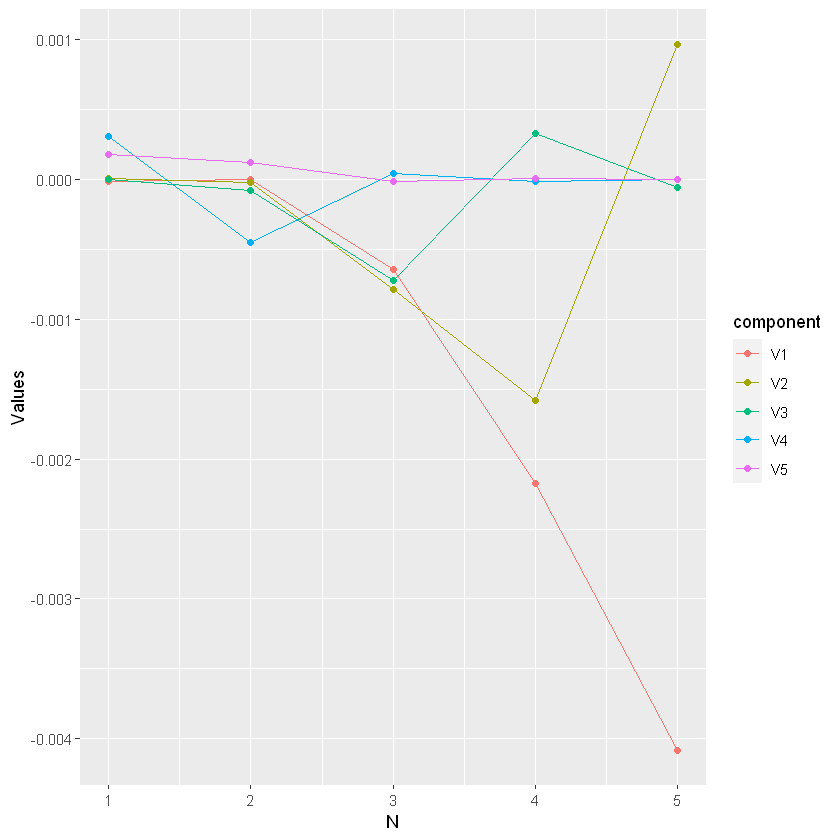

In [45]:
Bbase <- as.data.frame(B)
Bbase$N <- c(1,2,3,4,5)
Bbase <- pivot_longer(Bbase, cols=1:5,names_to= "component", values_to='Values')
ggplot(Bbase, aes(x = N, y = Values, color = component)) + 
  geom_line() +
  geom_point()

In [46]:
Y <- MatofAlphas*A
Y

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000000e+00,0.000000e+00,-5.064728e-05,8.831573e-03,-8.353388e-02
0.000000e+00,0.000000e+00,-1.845381e-03,-9.279336e-05,4.056322e-02
0.000000e+00,0.000000e+00,-4.792547e-03,-3.226817e-03,-7.378295e-03
0.000000e+00,0.000000e+00,3.234285e-03,-3.082272e-02,6.185093e-02
0.000000e+00,0.000000e+00,-2.934470e-05,1.449703e-02,-9.245033e-02
0.000000e+00,0.000000e+00,-7.316363e-04,-2.786607e-03,9.229225e-03
0.000000e+00,0.000000e+00,-6.127450e-03,2.124300e-02,-3.018883e-03
0.000000e+00,0.000000e+00,3.412909e-03,-3.454969e-02,-2.555338e-05
0.000000e+00,0.000000e+00,-5.386210e-04,2.886186e-03,9.430628e-02


In [47]:
W <- MatofAlphas*B
W

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000000e+00,0.000000e+00,-1.019466e-07,1.777684e-05,-6.681568e-05
0.000000e+00,0.000000e+00,-3.714520e-06,-7.422199e-08,3.244503e-05
0.000000e+00,0.000000e+00,-9.646792e-06,-2.581012e-06,-5.901626e-06
0.000000e+00,0.000000e+00,6.510207e-06,-2.465396e-05,3.406188e-05
0.000000e+00,0.000000e+00,-2.347174e-08,1.159564e-05,-5.091326e-05
0.000000e+00,0.000000e+00,-5.852090e-07,-2.228904e-06,5.082620e-06
0.000000e+00,0.000000e+00,-4.901121e-06,1.169872e-05,-1.662527e-06
0.000000e+00,0.000000e+00,2.729860e-06,-1.902684e-05,-1.407248e-08
0.000000e+00,0.000000e+00,-4.308231e-07,1.589449e-06,2.071655e-05


In [76]:
best_components <- W[,1:2]

In [51]:
librerias <- c("forecast","xts","rugarch","timeSeries","ggplot2","astsa","scales","lubridate","reshape2","quantmod","xtable","tseries")

In [52]:
if(length(setdiff(librerias, rownames(installed.packages()))) > 0){
  install.packages(setdiff(librerias, rownames(installed.packages())))}
invisible(sapply(librerias, require, character.only = TRUE,quietly = TRUE))

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'rugarch' was built under R version 3.6.3"
Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Warning message:
"package 'timeSeries' was built under R version 3.6.3"Warning message:
"package 'timeDate' was built under R version 3.6.2"
Attaching package: 'timeSeries'

The following object is masked from 'package:zoo':

    time<-


Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas

Warning message:
"package 'scales' was built under R version 3.6.3"Warning messag

In [77]:
Arima_1 <- auto.arima(best_components[,1],stepwise = F,approximation = F)
Box.test(Arima_1$residuals)
Arima_2 <- auto.arima(best_components[,2],stepwise = F,approximation = F)
Box.test(Arima_2$residuals)


	Box-Pierce test

data:  Arima_1$residuals
X-squared = 0.00015997, df = 1, p-value = 0.9899



	Box-Pierce test

data:  Arima_2$residuals
X-squared = 0.12981, df = 1, p-value = 0.7186


Simulaciones al futuro

In [78]:
future <- 52
simulations <- 1000
Sim_component_1 <- replicate(expr = simulate(object = Arima_1,nsim = future),n = simulations)
Sim_component_2 <- replicate(expr = simulate(object = Arima_2,nsim = future),n = simulations)
Bt1 <- t(B[,1])
Bt2 <- t(B[,2])
delta<-matrix(,nrow=future, ncol=simulations)

for (i in 1:future){
        for (j in 1:simulations){
                delta[i,j] <- sum(Sim_component_1[i,j]*Bt1)+sum(Sim_component_2[i,j]*Bt2)
        }
}
delta


1.147217e-10,1.634683e-09,3.510635e-10,-6.932161e-10,2.391815e-09,1.359885e-10,-1.140494e-09,-5.754767e-10,-1.720282e-09,-1.195990e-09,...,-9.227850e-10,5.796027e-09,-1.814608e-09,-5.407121e-09,-3.052429e-09,1.202543e-09,-2.781817e-09,2.755202e-09,-2.367132e-09,-2.583485e-09
1.457785e-09,1.946212e-09,6.513849e-09,2.177039e-09,3.268697e-09,6.607726e-09,-4.471338e-09,4.025739e-09,1.725014e-10,-6.211359e-10,...,4.855553e-09,9.228562e-09,-2.236964e-09,-7.662698e-10,1.022206e-10,-6.944326e-10,-2.513169e-09,-2.224937e-09,-1.807888e-09,-2.589298e-09
3.603603e-09,5.072238e-09,7.864799e-09,-4.475769e-09,2.181316e-09,6.029944e-10,-7.126199e-09,6.264204e-09,4.362035e-09,-3.389403e-09,...,5.666944e-09,6.470047e-09,-4.512294e-09,-2.276095e-09,-7.981269e-09,1.312199e-09,2.123340e-09,-4.305114e-10,3.032797e-09,-7.346740e-10
4.487991e-09,2.483117e-09,-2.484211e-10,-1.822878e-09,-3.105577e-09,-4.795071e-09,1.215770e-10,3.773400e-09,5.577842e-09,-1.521330e-09,...,1.988788e-09,-2.125596e-09,-3.245779e-09,-3.505313e-09,-7.198010e-09,-1.129796e-09,3.361754e-09,1.790915e-09,-1.915555e-09,-3.602237e-10
-1.172072e-08,4.931905e-09,-1.755549e-09,1.203096e-09,-1.464086e-09,-1.921315e-09,7.801776e-10,-4.156863e-09,1.940889e-09,-2.865707e-10,...,-1.637427e-09,-3.693256e-09,-1.647114e-09,-2.104495e-09,1.417935e-09,-2.755461e-09,3.311553e-09,4.065003e-09,-6.948772e-09,-9.405292e-10
-1.583307e-09,1.875132e-09,-3.034662e-09,4.621798e-09,2.171961e-09,-4.566422e-10,-4.962467e-09,-4.928332e-09,9.461084e-10,-2.475374e-09,...,1.372656e-09,2.563377e-09,3.629356e-09,-4.415446e-09,2.785585e-09,3.922908e-09,-6.243368e-09,2.685192e-09,-4.325419e-09,2.031203e-09
9.053589e-10,-1.613364e-09,-3.240507e-09,3.039583e-09,5.059304e-09,-1.212164e-09,-5.924951e-09,-3.405259e-09,-2.956807e-09,5.116532e-09,...,-8.317496e-10,3.231776e-09,-2.209599e-09,3.855868e-10,2.738355e-09,-2.231390e-09,-8.119616e-09,-2.676530e-09,9.923003e-10,5.499375e-09
-3.316660e-09,-3.566381e-09,-3.224837e-09,1.037915e-08,4.419238e-09,-7.540245e-09,-7.508684e-09,-2.254940e-09,-5.128550e-09,-5.893008e-09,...,1.672174e-09,-2.843534e-09,-8.253845e-10,2.419859e-09,7.339207e-10,-3.348417e-09,-6.669482e-09,-9.472584e-10,-5.070196e-09,1.323724e-09
5.837310e-10,-1.458249e-09,4.537140e-09,3.148621e-09,1.966611e-09,9.759628e-10,-4.466371e-09,3.646975e-09,-5.784595e-09,-8.764099e-10,...,6.284901e-10,1.057036e-09,1.134970e-09,1.192097e-09,2.899076e-09,-2.045460e-09,-1.337896e-09,-4.631029e-09,-1.323773e-09,-1.586008e-09
1.512372e-09,-2.079724e-10,-2.838376e-09,-1.921961e-09,-1.856414e-09,6.555384e-09,-7.301697e-09,3.228134e-09,-1.163484e-09,-2.160272e-09,...,-2.021927e-09,3.589407e-09,3.676045e-10,3.427986e-09,5.289722e-09,-5.522592e-09,2.430360e-09,-4.954949e-09,-1.162023e-09,1.895075e-09
-1.022931e-10,7.448330e-09,-3.078937e-09,-7.677267e-10,3.760807e-09,-5.851491e-11,-5.301607e-09,-4.007208e-12,2.326552e-09,4.001676e-10,...,-2.391493e-10,1.214728e-09,-6.779114e-10,1.854753e-11,-1.927460e-09,-5.323034e-09,2.467384e-09,-5.370628e-09,-9.944242e-10,2.791949e-12


In [79]:

forwards <- list()
alpha <- c( 0.000947582290432353,0.00474077085158422,0.0310741501203435,0.0572666472357455,0.108575410857186)
for (i in 1:simulations){
        newalph <- alpha
        for (j in 1:future){
                newalph <-  newalph + delta[j,i] 
                if (j==52){
                        forwards <- append(forwards, newalph)
                }    
        }
}
matforwards <- matrix(forwards, ncol=5)

In [80]:
matforwards

0.0009476288,0.0009476018,0.0009476254,0.0009476302,0.0009475528
0.004740817,0.00474079,0.004740814,0.004740819,0.004740741
0.0310742,0.03107417,0.03107419,0.0310742,0.03107412
0.05726669,0.05726667,0.05726669,0.0572667,0.05726662
0.1085755,0.1085754,0.1085755,0.1085755,0.1085754
0.0009475955,0.0009476143,0.0009475602,0.0009476324,0.0009475865
0.004740784,0.004740803,0.004740749,0.004740821,0.004740775
0.03107416,0.03107418,0.03107413,0.0310742,0.03107415
0.05726666,0.05726668,0.05726663,0.0572667,0.05726665
0.1085754,0.1085754,0.1085754,0.1085755,0.1085754
0.0009475904,0.0009476017,0.0009475612,0.0009475156,0.0009476637


In [81]:
couponsim <- list()
c <- 3.93957166428661
for (i in 1:simulations){
    alpha <- lapply(as.vector(matforwards[i,]), as.numeric)
        pvnotional <- DiscountFactor(as.numeric(alpha[4]), 84 )*100
        pvnotional
            pvcoupon <- DiscountFactor(as.numeric(alpha[2]), 12)*RateConverter(c, 12,today) + DiscountFactor(as.numeric(alpha[2]), 24)*RateConverter(c,24,today) +
                DiscountFactor(as.numeric(alpha[3]), 36)*RateConverter(c, 36,today) +DiscountFactor(as.numeric(alpha[3]), 48)*RateConverter(c, 48,today) +
                DiscountFactor(as.numeric(alpha[4]), 60)*RateConverter(c, 60,today) + DiscountFactor(as.numeric(alpha[4]), 72)*RateConverter(c, 72,today) +  
                DiscountFactor(as.numeric(alpha[4]), 84)*RateConverter(c, 84,today) + DiscountFactor(as.numeric(alpha[4]), 84)*RateConverter(c, 84,today)
                result <-pvnotional + pvcoupon
                couponsim <- append(couponsim,list(result))
    
}
matcoupon <- matrix(couponsim, ncol=1)

In [82]:
matcoupon <- as.data.frame(matcoupon)
bondvaluesim <- as.numeric(matcoupon$V1)
bondvaluesim


[1] 142.52680 139.04956 117.20935  98.99992  71.37640 142.52680 139.04956
   [8] 117.20935  98.99992  71.37640 142.52690 139.04966 117.20943  98.99999
  [15]  71.37645 142.52686 139.04961 117.20939  98.99996  71.37643 142.52681
  [22] 139.04957 117.20936  98.99993  71.37641 142.52683 139.04959 117.20937
  [29]  98.99995  71.37642 142.52683 139.04959 117.20937  98.99995  71.37642
  [36] 142.52683 139.04959 117.20937  98.99995  71.37642 142.52679 139.04954
  [43] 117.20934  98.99991  71.37639 142.52682 139.04958 117.20936  98.99994
  [50]  71.37641 142.52688 139.04964 117.20942  98.99998  71.37644 142.52688
  [57] 139.04964 117.20941  98.99998  71.37644 142.52685 139.04961 117.20939
  [64]  98.99996  71.37642 142.52680 139.04956 117.20935  98.99993  71.37640
  [71] 142.52681 139.04957 117.20935  98.99993  71.37641 142.52683 139.04959
  [78] 117.20937  98.99994  71.37642 142.52681 139.04957 117.20936  98.99993
  [85]  71.37641 142.52684 139.04960 117.20938  98.99995  71.37642 142.52684
  [92] 139.04960 117.20938  98.99996  71.37642 142.52688 139.04964 117.20941
  [99]  98.99998  71.37644 142.52682 139.04958 117.20937  98.99994  71.37641
 [106] 142.52680 139.04955 117.20934  98.99992  71.37640 142.52684 139.04959
 [113] 117.20938  98.99995  71.37642 142.52678 139.04954 117.20933  98.99991
 [120]  71.37639 142.52685 139.04961 117.20939  98.99996  71.37643 142.52686
 [127] 139.04962 117.20940  98.99997  71.37643 142.52690 139.04966 117.20943
 [134]  98.99999  71.37645 142.52683 139.04959 117.20937  98.99994  71.37642
 [141] 142.52679 139.04955 117.20934  98.99992  71.37640 142.52683 139.04959
 [148] 117.20937  98.99995  71.37642 142.52680 139.04956 117.20935  98.99992
 [155]  71.37640 142.52685 139.04961 117.20939  98.99996  71.37642 142.52677
 [162] 139.04953 117.20933  98.99991  71.37639 142.52682 139.04958 117.20937
 [169]  98.99994  71.37641 142.52684 139.04960 117.20938  98.99995  71.37642
 [176] 142.52682 139.04958 117.20937  98.99994  71.37641 142.52676 139.04952
 [183] 117.20931  98.99990  71.37638 142.52684 139.04960 117.20938  98.99995
 [190]  71.37642 142.52688 139.04964 117.20941  98.99998  71.37644 142.52679
 [197] 139.04955 117.20934  98.99992  71.37640 142.52682 139.04958 117.20937
 [204]  98.99994  71.37641 142.52684 139.04960 117.20938  98.99995  71.37642
 [211] 142.52681 139.04957 117.20936  98.99993  71.37641 142.52679 139.04955
 [218] 117.20934  98.99992  71.37640 142.52684 139.04960 117.20938  98.99995
 [225]  71.37642 142.52679 139.04955 117.20934  98.99992  71.37640 142.52689
 [232] 139.04965 117.20942  98.99999  71.37645 142.52690 139.04965 117.20943
 [239]  98.99999  71.37645 142.52683 139.04959 117.20937  98.99995  71.37642
 [246] 142.52687 139.04962 117.20940  98.99997  71.37643 142.52683 139.04959
 [253] 117.20938  98.99995  71.37642 142.52689 139.04965 117.20942  98.99999
 [260]  71.37645 142.52686 139.04962 117.20940  98.99997  71.37643 142.52685
 [267] 139.04961 117.20939  98.99996  71.37643 142.52683 139.04959 117.20938
 [274]  98.99995  71.37642 142.52683 139.04959 117.20937  98.99994  71.37642
 [281] 142.52687 139.04962 117.20940  98.99997  71.37643 142.52681 139.04957
 [288] 117.20936  98.99993  71.37641 142.52687 139.04963 117.20941  98.99997
 [295]  71.37644 142.52688 139.04964 117.20941  98.99998  71.37644 142.52687
 [302] 139.04962 117.20940  98.99997  71.37643 142.52683 139.04959 117.20938
 [309]  98.99995  71.37642 142.52680 139.04956 117.20935  98.99992  71.37640
 [316] 142.52686 139.04961 117.20939  98.99996  71.37643 142.52685 139.04961
 [323] 117.20939  98.99996  71.37643 142.52689 139.04964 117.20942  98.99998
 [330]  71.37644 142.52680 139.04956 117.20935  98.99992  71.37640 142.52686
 [337] 139.04962 117.20940  98.99997  71.37643 142.52688 139.04964 117.20941
 [344]  98.99998  71.37644 142.52683 139.04959 117.20938  98.99995  71.37642
 [351] 142.52684 139.04960 117.20938  98.99995  71.37642 142.52687 139.04963
 [358] 117.20941  98.99997  71.37644 142.52687 139.04962 117.20940  98.99997

[1] 113832.4

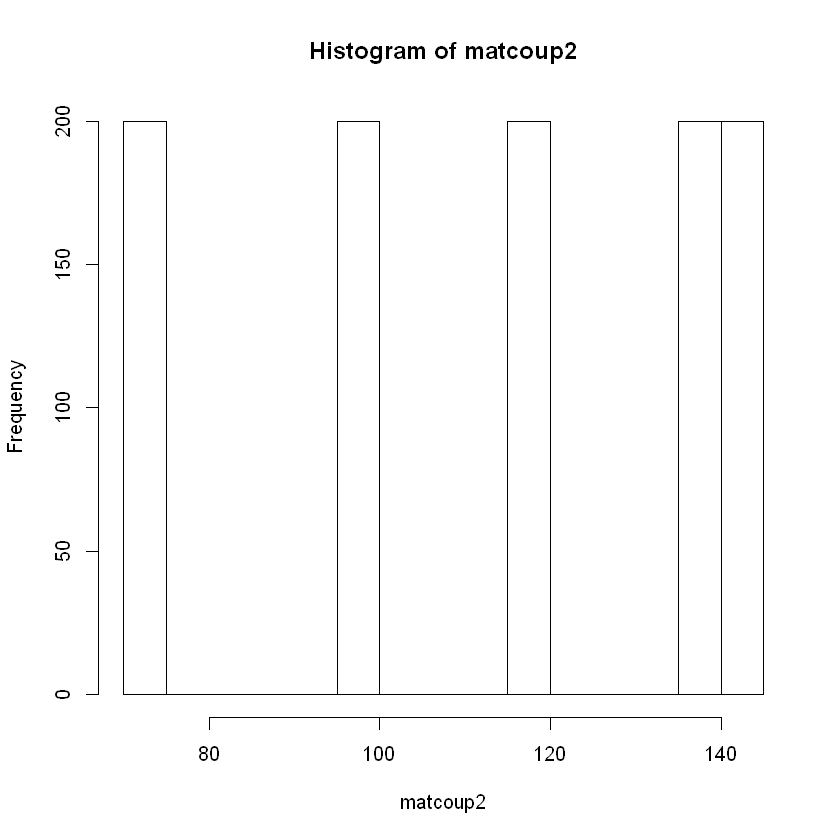

In [87]:

hist(bondvaluesim)
summary(bondvaluesim)